# Multi-Horizon Solar Power Forecasting for Grid Integration

## Problem Statement

Solar power is inherently **intermittent** - output varies with weather and time of day. For grid operators, accurate forecasting is critical:

- **Supply-Demand Balancing**: Grid must match generation with load in real-time
- **Reserve Planning**: Backup power must be scheduled ahead of time
- **Economic Dispatch**: Optimal scheduling of generators requires forecasts

### Forecasting Horizons

| Horizon | Use Case |
|---------|----------|
| 15 min (t+1) | Real-time balancing, AGC |
| 1 hour (t+4) | Economic dispatch, reserve scheduling |
| 4 hours (t+16) | Unit commitment, day-ahead planning |

### Approach

1. **Feature Engineering**: Time, solar position, lag features, rolling statistics
2. **Multi-Horizon Targets**: Predict 15min, 1hr, 4hr ahead simultaneously
3. **Model Comparison**: Ridge, XGBoost, LightGBM, CatBoost
4. **Time Series Cross-Validation**: Walk-forward validation
5. **Error Analysis**: By time of day, ramp events
6. **Uncertainty Quantification**: Prediction intervals via quantile regression
7. **SHAP Analysis**: Model interpretability and feature importance

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 11

## 1. Data Loading

In [94]:
# Load data
gen = pd.read_csv('../data/Plant_1_Generation_Data.csv')
weather = pd.read_csv('../data/Plant_1_Weather_Sensor_Data.csv')

# Convert datetime
gen['DATE_TIME'] = pd.to_datetime(gen['DATE_TIME'], dayfirst=True)
weather['DATE_TIME'] = pd.to_datetime(weather['DATE_TIME'])

print(f"Generation: {gen.shape}")
print(f"Weather: {weather.shape}")
print(f"\nPeriod: {gen['DATE_TIME'].min()} to {gen['DATE_TIME'].max()}")
print(f"Duration: {(gen['DATE_TIME'].max() - gen['DATE_TIME'].min()).days} days")

Generation: (68778, 7)
Weather: (3182, 6)

Period: 2020-05-15 00:00:00 to 2020-06-17 23:45:00
Duration: 33 days


In [95]:
# Aggregate generation by timestamp (sum across inverters)
gen_agg = gen.groupby('DATE_TIME').agg({'DC_POWER': 'sum'}).reset_index()

# Merge with weather
df = pd.merge(
    gen_agg,
    weather[['DATE_TIME', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']],
    on='DATE_TIME',
    how='inner'
).sort_values('DATE_TIME').reset_index(drop=True)

print(f"Merged dataset: {df.shape}")
print(f"Time resolution: 15 minutes")
df.head()

Merged dataset: (3157, 5)
Time resolution: 15 minutes


,DATE_TIME,DC_POWER,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,0.0,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,0.0,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,0.0,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,0.0,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,0.0,24.621525,22.165423,0.0


## 2. Feature Engineering

### 2.1 Time-Based Features

In [96]:
# Time features
df['hour'] = df['DATE_TIME'].dt.hour
df['minute'] = df['DATE_TIME'].dt.minute
df['dayofweek'] = df['DATE_TIME'].dt.dayofweek
df['day'] = df['DATE_TIME'].dt.day

# Time slot (0-95 for 15-min intervals in a day)
df['time_slot'] = df['hour'] * 4 + df['minute'] // 15

# Cyclical encoding (important for ML models to understand time is circular)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

print("Time features added")

Time features added


### 2.2 Solar Position Features

Solar power depends on sun position. We approximate using hour angle.

In [97]:
# Approximate solar position
# Hour angle: 0 at solar noon (~12:00), negative morning, positive afternoon
df['hour_angle'] = (df['hour'] + df['minute']/60 - 12) * 15  # degrees

# Approximate solar elevation (simplified - assumes ~20° latitude, summer)
# This captures the basic pattern: low in morning/evening, high at noon
df['solar_elevation_approx'] = 90 - abs(df['hour_angle'])
df['solar_elevation_approx'] = df['solar_elevation_approx'].clip(lower=0)

# Is it daytime? (rough approximation)
df['is_daytime'] = ((df['hour'] >= 6) & (df['hour'] <= 18)).astype(int)

print("Solar position features added")

Solar position features added


### 2.3 Temperature Efficiency

Solar panel efficiency decreases with temperature (~0.4%/°C above 25°C for typical Si panels)

In [98]:
# Temperature difference (solar heating effect)
df['temp_diff'] = df['MODULE_TEMPERATURE'] - df['AMBIENT_TEMPERATURE']

# Temperature efficiency factor (reference: 25°C)
# Efficiency drops ~0.4% per degree above 25°C
TEMP_COEFF = -0.004  # -0.4%/°C
REF_TEMP = 25
df['temp_efficiency'] = 1 + TEMP_COEFF * (df['MODULE_TEMPERATURE'] - REF_TEMP)

print("Temperature features added")
print(f"Temp efficiency range: {df['temp_efficiency'].min():.3f} to {df['temp_efficiency'].max():.3f}")

Temperature features added
Temp efficiency range: 0.838 to 1.027


### 2.4 Lag Features (Historical Values)

For forecasting, we use past values to predict future. **Critical: We can only use data available at prediction time.**

In [99]:
# Lag features for DC_POWER
# t-1: 15 min ago, t-4: 1 hour ago, t-8: 2 hours ago, t-96: same time yesterday
lag_periods = [1, 2, 4, 8, 16, 96]

for lag in lag_periods:
    df[f'power_lag_{lag}'] = df['DC_POWER'].shift(lag)

# Lag features for irradiation
for lag in [1, 4, 8]:
    df[f'irr_lag_{lag}'] = df['IRRADIATION'].shift(lag)

print(f"Lag features added: {[f'power_lag_{l}' for l in lag_periods]}")

Lag features added: ['power_lag_1', 'power_lag_2', 'power_lag_4', 'power_lag_8', 'power_lag_16', 'power_lag_96']


### 2.5 Rolling Statistics

Capture recent trends and variability

In [100]:
# Rolling statistics for DC_POWER
# Window = 4 (1 hour), 8 (2 hours)

# 1-hour rolling stats
df['power_roll_mean_4'] = df['DC_POWER'].shift(1).rolling(window=4).mean()
df['power_roll_std_4'] = df['DC_POWER'].shift(1).rolling(window=4).std()
df['power_roll_max_4'] = df['DC_POWER'].shift(1).rolling(window=4).max()

# 2-hour rolling stats
df['power_roll_mean_8'] = df['DC_POWER'].shift(1).rolling(window=8).mean()

# Irradiation rolling
df['irr_roll_mean_4'] = df['IRRADIATION'].shift(1).rolling(window=4).mean()

print("Rolling statistics added")

Rolling statistics added


### 2.6 Ramp Rate (Rate of Change)

Important for grid stability - rapid changes are harder to manage

In [101]:
# Ramp rate: change from previous timestep
df['power_ramp'] = df['DC_POWER'].diff()
df['power_ramp_lag1'] = df['power_ramp'].shift(1)

# Irradiation change
df['irr_ramp'] = df['IRRADIATION'].diff()
df['irr_ramp_lag1'] = df['irr_ramp'].shift(1)

print("Ramp rate features added")

Ramp rate features added


### 2.7 Create Target Variables (Multi-Horizon)

In [102]:
# Target: Future DC_POWER
# t+1: 15 min ahead
# t+4: 1 hour ahead
# t+16: 4 hours ahead

df['target_15min'] = df['DC_POWER'].shift(-1)   # t+1
df['target_1hr'] = df['DC_POWER'].shift(-4)     # t+4
df['target_4hr'] = df['DC_POWER'].shift(-16)    # t+16

print("Target variables created:")
print("  - target_15min (t+1)")
print("  - target_1hr (t+4)")
print("  - target_4hr (t+16)")

Target variables created:
  - target_15min (t+1)
  - target_1hr (t+4)
  - target_4hr (t+16)


In [103]:
# Check all features
print(f"Total features: {len(df.columns)}")
print(f"\nColumns:\n{df.columns.tolist()}")

Total features: 38

Columns:
['DATE_TIME', 'DC_POWER', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'hour', 'minute', 'dayofweek', 'day', 'time_slot', 'hour_sin', 'hour_cos', 'hour_angle', 'solar_elevation_approx', 'is_daytime', 'temp_diff', 'temp_efficiency', 'power_lag_1', 'power_lag_2', 'power_lag_4', 'power_lag_8', 'power_lag_16', 'power_lag_96', 'irr_lag_1', 'irr_lag_4', 'irr_lag_8', 'power_roll_mean_4', 'power_roll_std_4', 'power_roll_max_4', 'power_roll_mean_8', 'irr_roll_mean_4', 'power_ramp', 'power_ramp_lag1', 'irr_ramp', 'irr_ramp_lag1', 'target_15min', 'target_1hr', 'target_4hr']


In [104]:
# Drop rows with NaN (from lag/rolling/target creation)
df_clean = df.dropna().reset_index(drop=True)
print(f"Dataset after dropping NaN: {df_clean.shape}")
print(f"Samples lost: {len(df) - len(df_clean)}")

Dataset after dropping NaN: (3045, 38)
Samples lost: 112


## 3. Train/Test Split

**Important**: For time series, we cannot shuffle. Use last portion as test set.

In [105]:
# Define feature columns (exclude targets, datetime, and current DC_POWER)
exclude_cols = ['DATE_TIME', 'DC_POWER', 'target_15min', 'target_1hr', 'target_4hr', 'power_ramp']
feature_cols = [c for c in df_clean.columns if c not in exclude_cols]

print(f"Features ({len(feature_cols)}):")
print(feature_cols)

Features (32):
['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'hour', 'minute', 'dayofweek', 'day', 'time_slot', 'hour_sin', 'hour_cos', 'hour_angle', 'solar_elevation_approx', 'is_daytime', 'temp_diff', 'temp_efficiency', 'power_lag_1', 'power_lag_2', 'power_lag_4', 'power_lag_8', 'power_lag_16', 'power_lag_96', 'irr_lag_1', 'irr_lag_4', 'irr_lag_8', 'power_roll_mean_4', 'power_roll_std_4', 'power_roll_max_4', 'power_roll_mean_8', 'irr_roll_mean_4', 'power_ramp_lag1', 'irr_ramp', 'irr_ramp_lag1']


In [106]:
# Train/Test split (80/20, no shuffle)
train_size = int(len(df_clean) * 0.8)

train_df = df_clean[:train_size]
test_df = df_clean[train_size:]

print(f"Train: {len(train_df)} samples ({train_df['DATE_TIME'].min()} to {train_df['DATE_TIME'].max()})")
print(f"Test: {len(test_df)} samples ({test_df['DATE_TIME'].min()} to {test_df['DATE_TIME'].max()})")

Train: 2436 samples (2020-05-16 02:45:00 to 2020-06-11 11:00:00)
Test: 609 samples (2020-06-11 11:15:00 to 2020-06-17 19:45:00)


In [107]:
# Prepare X and y
X_train = train_df[feature_cols]
X_test = test_df[feature_cols]

# We'll train separate models for each horizon
y_train_15min = train_df['target_15min']
y_train_1hr = train_df['target_1hr']
y_train_4hr = train_df['target_4hr']

y_test_15min = test_df['target_15min']
y_test_1hr = test_df['target_1hr']
y_test_4hr = test_df['target_4hr']

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (2436, 32)
X_test: (609, 32)


## 4. Model Training & Comparison

We compare four models:
1. **Ridge Regression** (Linear baseline with regularization)
2. **XGBoost** (Gradient boosting)
3. **LightGBM** (Fast gradient boosting)
4. **CatBoost** (Gradient boosting with categorical support)

In [108]:
# Evaluation function
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    # Normalized RMSE (% of mean)
    nrmse = rmse / y_true.mean() * 100
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'nRMSE%': nrmse}

def print_metrics(metrics, name):
    print(f"{name}:")
    print(f"  RMSE: {metrics['RMSE']:,.0f} kW")
    print(f"  MAE:  {metrics['MAE']:,.0f} kW")
    print(f"  R²:   {metrics['R2']:.4f}")
    print(f"  nRMSE: {metrics['nRMSE%']:.1f}%")

In [109]:
# Scale features for Ridge regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [110]:
# Initialize models
models = {
    'Ridge': Ridge(alpha=1.0),
    'XGBoost': XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    ),
    'LightGBM': LGBMRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbosity=-1
    ),
    'CatBoost': CatBoostRegressor(
        iterations=100,
        depth=5,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42,
        verbose=0
    )
}

# Store results
results = {}

### 4.1 15-Minute Ahead Forecasting

In [111]:
print("="*60)
print("15-MINUTE AHEAD FORECASTING (t+1)")
print("="*60)

results['15min'] = {}

for name, model in models.items():
    # Use scaled data for Ridge, original for tree models
    if name == 'Ridge':
        model.fit(X_train_scaled, y_train_15min)
        pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train_15min)
        pred = model.predict(X_test)
    
    metrics = evaluate(y_test_15min, pred)
    results['15min'][name] = {'metrics': metrics, 'predictions': pred}
    print_metrics(metrics, name)
    print()

15-MINUTE AHEAD FORECASTING (t+1)
Ridge:
  RMSE: 21,078 kW
  MAE:  11,850 kW
  R²:   0.9339
  nRMSE: 32.5%

XGBoost:
  RMSE: 22,901 kW
  MAE:  11,389 kW
  R²:   0.9220
  nRMSE: 35.3%

LightGBM:
  RMSE: 22,111 kW
  MAE:  10,985 kW
  R²:   0.9273
  nRMSE: 34.0%

CatBoost:
  RMSE: 21,886 kW
  MAE:  11,346 kW
  R²:   0.9288
  nRMSE: 33.7%



### 4.2 1-Hour Ahead Forecasting

In [112]:
print("="*60)
print("1-HOUR AHEAD FORECASTING (t+4)")
print("="*60)

results['1hr'] = {}

for name, model in models.items():
    if name == 'Ridge':
        model.fit(X_train_scaled, y_train_1hr)
        pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train_1hr)
        pred = model.predict(X_test)
    
    metrics = evaluate(y_test_1hr, pred)
    results['1hr'][name] = {'metrics': metrics, 'predictions': pred}
    print_metrics(metrics, name)
    print()

1-HOUR AHEAD FORECASTING (t+4)
Ridge:
  RMSE: 28,751 kW
  MAE:  18,756 kW
  R²:   0.8762
  nRMSE: 44.9%

XGBoost:
  RMSE: 29,175 kW
  MAE:  15,692 kW
  R²:   0.8725
  nRMSE: 45.6%

LightGBM:
  RMSE: 27,872 kW
  MAE:  14,784 kW
  R²:   0.8836
  nRMSE: 43.5%

CatBoost:
  RMSE: 28,323 kW
  MAE:  15,387 kW
  R²:   0.8798
  nRMSE: 44.2%



### 4.3 4-Hour Ahead Forecasting

In [113]:
print("="*60)
print("4-HOUR AHEAD FORECASTING (t+16)")
print("="*60)

results['4hr'] = {}

for name, model in models.items():
    if name == 'Ridge':
        model.fit(X_train_scaled, y_train_4hr)
        pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train_4hr)
        pred = model.predict(X_test)
    
    metrics = evaluate(y_test_4hr, pred)
    results['4hr'][name] = {'metrics': metrics, 'predictions': pred}
    print_metrics(metrics, name)
    print()

4-HOUR AHEAD FORECASTING (t+16)
Ridge:
  RMSE: 34,561 kW
  MAE:  25,276 kW
  R²:   0.8173
  nRMSE: 56.8%

XGBoost:
  RMSE: 30,871 kW
  MAE:  17,060 kW
  R²:   0.8542
  nRMSE: 50.7%

LightGBM:
  RMSE: 30,041 kW
  MAE:  16,132 kW
  R²:   0.8620
  nRMSE: 49.4%

CatBoost:
  RMSE: 28,570 kW
  MAE:  16,315 kW
  R²:   0.8752
  nRMSE: 46.9%



## 5. Results Summary

In [114]:
# Summary table
summary_data = []

for horizon in ['15min', '1hr', '4hr']:
    for model_name in models.keys():
        m = results[horizon][model_name]['metrics']
        summary_data.append({
            'Horizon': horizon,
            'Model': model_name,
            'RMSE': m['RMSE'],
            'MAE': m['MAE'],
            'R²': m['R2'],
            'nRMSE%': m['nRMSE%']
        })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*60)
print("SUMMARY: ALL MODELS AND HORIZONS")
print("="*60)
summary_df


SUMMARY: ALL MODELS AND HORIZONS


,Horizon,Model,RMSE,MAE,R²,nRMSE%
0,15min,Ridge,21078.176863,11849.786529,0.933941,32.454383
1,15min,XGBoost,22901.406116,11388.720953,0.922019,35.261636
2,15min,LightGBM,22111.312697,10985.186544,0.927307,34.045117
3,15min,CatBoost,21885.946134,11345.515699,0.928781,33.698117
4,1hr,Ridge,28751.265519,18755.855347,0.876183,44.889482
5,1hr,XGBoost,29175.456129,15691.867695,0.872503,45.551773
6,1hr,LightGBM,27872.390139,14784.200387,0.883637,43.517290
7,1hr,CatBoost,28323.403998,15387.255896,0.879841,44.221460
8,4hr,Ridge,34560.567603,25275.813045,0.817318,56.778530
9,4hr,XGBoost,30870.932651,17060.062568,0.854241,50.716938


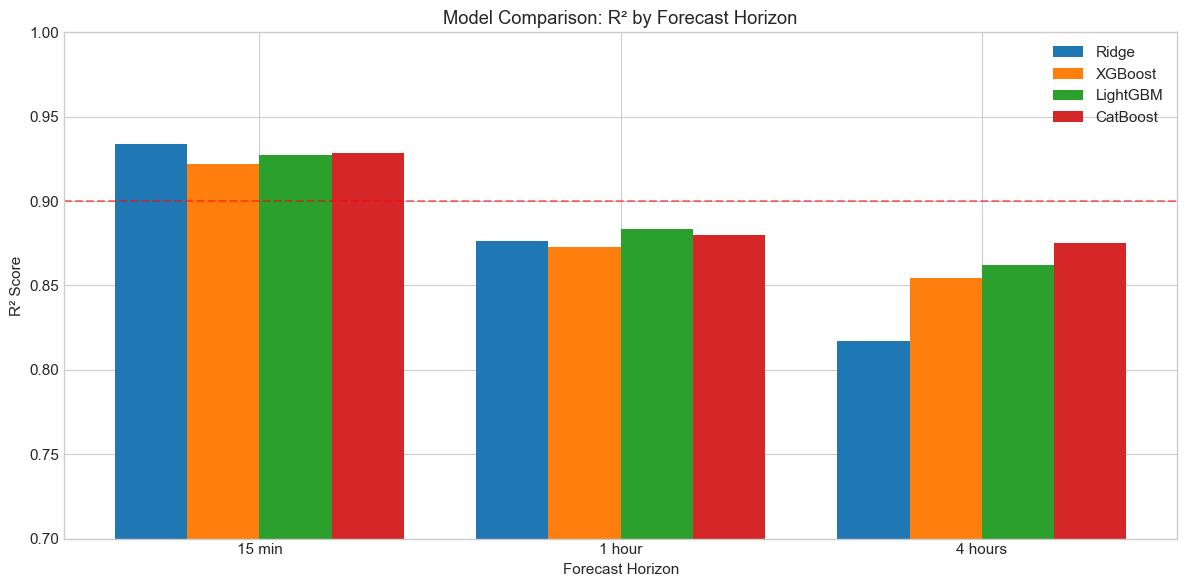

In [115]:
# Visualization: R² comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(3)
width = 0.2

for i, model_name in enumerate(models.keys()):
    r2_values = [results[h][model_name]['metrics']['R2'] for h in ['15min', '1hr', '4hr']]
    ax.bar(x + i*width, r2_values, width, label=model_name)

ax.set_ylabel('R² Score')
ax.set_xlabel('Forecast Horizon')
ax.set_title('Model Comparison: R² by Forecast Horizon')
ax.set_xticks(x + 1.5*width)
ax.set_xticklabels(['15 min', '1 hour', '4 hours'])
ax.legend()
ax.set_ylim([0.7, 1])
ax.axhline(y=0.9, color='r', linestyle='--', alpha=0.5, label='0.9 threshold')

plt.tight_layout()
plt.show()

## 6. Time Series Cross-Validation

Proper validation for time series using walk-forward approach

In [116]:
# Time Series CV for all models (1-hour horizon)
tscv = TimeSeriesSplit(n_splits=5)

X_full = df_clean[feature_cols]
y_full = df_clean['target_1hr']

cv_scores = {'Ridge': [], 'XGBoost': [], 'LightGBM': [], 'CatBoost': []}

print("Time Series Cross-Validation (1-hour horizon)")
print("="*50)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_full)):
    X_tr, X_val = X_full.iloc[train_idx], X_full.iloc[val_idx]
    y_tr, y_val = y_full.iloc[train_idx], y_full.iloc[val_idx]
    
    # Scale for Ridge
    scaler_cv = StandardScaler()
    X_tr_scaled = scaler_cv.fit_transform(X_tr)
    X_val_scaled = scaler_cv.transform(X_val)
    
    print(f"\nFold {fold+1}: Train={len(train_idx)}, Val={len(val_idx)}")
    
    for name in cv_scores.keys():
        if name == 'Ridge':
            model = Ridge(alpha=1.0)
            model.fit(X_tr_scaled, y_tr)
            pred = model.predict(X_val_scaled)
        elif name == 'XGBoost':
            model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, verbosity=0, n_jobs=-1)
            model.fit(X_tr, y_tr)
            pred = model.predict(X_val)
        elif name == 'LightGBM':
            model = LGBMRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, verbosity=-1, n_jobs=-1)
            model.fit(X_tr, y_tr)
            pred = model.predict(X_val)
        else:  # CatBoost
            model = CatBoostRegressor(iterations=100, depth=5, learning_rate=0.1, verbose=0)
            model.fit(X_tr, y_tr)
            pred = model.predict(X_val)
        
        r2 = r2_score(y_val, pred)
        cv_scores[name].append(r2)
        print(f"  {name}: R²={r2:.4f}")

print("\n" + "="*50)
print("CV Results (Mean ± Std):")
for name, scores in cv_scores.items():
    print(f"  {name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

Time Series Cross-Validation (1-hour horizon)

Fold 1: Train=510, Val=507
  Ridge: R²=0.8592
  XGBoost: R²=0.8630
  LightGBM: R²=0.8547
  CatBoost: R²=0.8755

Fold 2: Train=1017, Val=507
  Ridge: R²=0.8091
  XGBoost: R²=0.8447
  LightGBM: R²=0.8527
  CatBoost: R²=0.8724

Fold 3: Train=1524, Val=507
  Ridge: R²=0.8523
  XGBoost: R²=0.8648
  LightGBM: R²=0.8677
  CatBoost: R²=0.8687

Fold 4: Train=2031, Val=507
  Ridge: R²=0.8868
  XGBoost: R²=0.8988
  LightGBM: R²=0.8928
  CatBoost: R²=0.8998

Fold 5: Train=2538, Val=507
  Ridge: R²=0.8791
  XGBoost: R²=0.8846
  LightGBM: R²=0.8812
  CatBoost: R²=0.8799

CV Results (Mean ± Std):
  Ridge: 0.8573 ± 0.0272
  XGBoost: 0.8712 ± 0.0187
  LightGBM: 0.8698 ± 0.0154
  CatBoost: 0.8792 ± 0.0109


## 7. Error Analysis

In [117]:
# Use best model (LightGBM) for 1-hour horizon
best_model = LGBMRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, verbosity=-1, n_jobs=-1)
best_model.fit(X_train, y_train_1hr)
best_pred = best_model.predict(X_test)

# Add predictions to test dataframe
test_analysis = test_df.copy()
test_analysis['predicted'] = best_pred
test_analysis['error'] = test_analysis['target_1hr'] - test_analysis['predicted']
test_analysis['abs_error'] = np.abs(test_analysis['error'])

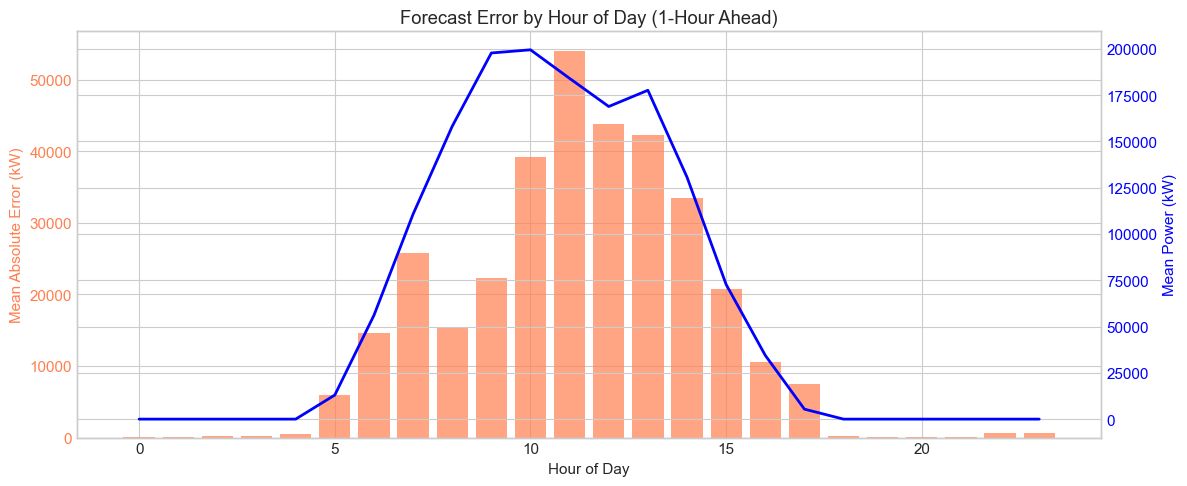

In [118]:
# Error by hour of day
hourly_error = test_analysis.groupby('hour').agg({
    'abs_error': 'mean',
    'target_1hr': 'mean'
}).rename(columns={'abs_error': 'MAE', 'target_1hr': 'Mean Power'})

fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.bar(hourly_error.index, hourly_error['MAE'], color='coral', alpha=0.7, label='MAE')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Mean Absolute Error (kW)', color='coral')
ax1.tick_params(axis='y', labelcolor='coral')

ax2 = ax1.twinx()
ax2.plot(hourly_error.index, hourly_error['Mean Power'], 'b-', linewidth=2, label='Mean Power')
ax2.set_ylabel('Mean Power (kW)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Forecast Error by Hour of Day (1-Hour Ahead)')
plt.tight_layout()
plt.show()

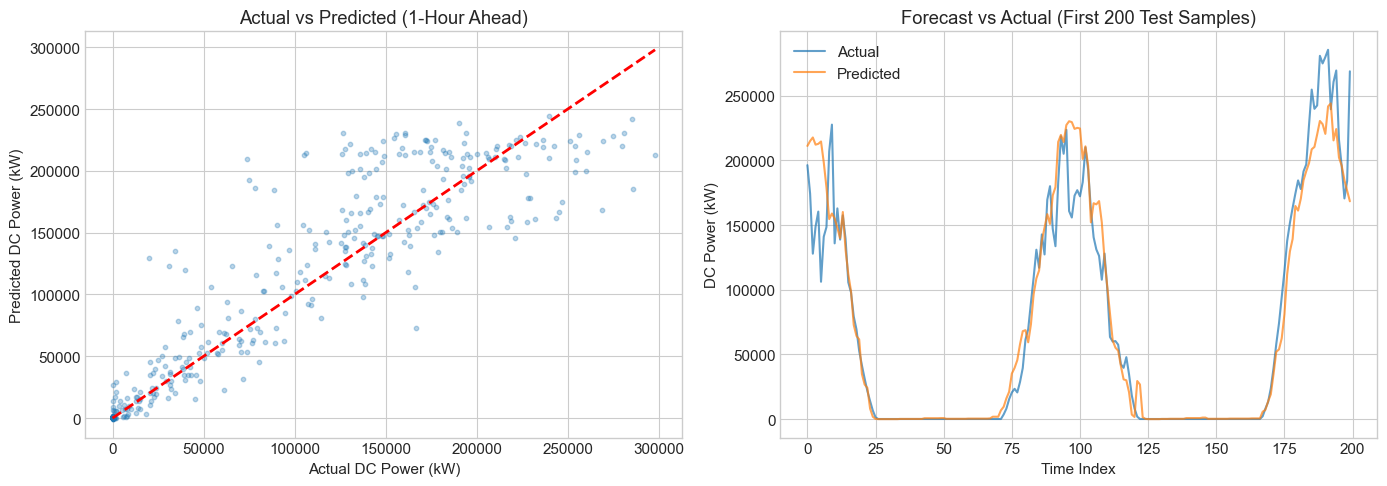

In [119]:
# Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(test_analysis['target_1hr'], test_analysis['predicted'], alpha=0.3, s=10)
max_val = max(test_analysis['target_1hr'].max(), test_analysis['predicted'].max())
axes[0].plot([0, max_val], [0, max_val], 'r--', lw=2)
axes[0].set_xlabel('Actual DC Power (kW)')
axes[0].set_ylabel('Predicted DC Power (kW)')
axes[0].set_title('Actual vs Predicted (1-Hour Ahead)')

# Time series
n = 200
axes[1].plot(range(n), test_analysis['target_1hr'].values[:n], label='Actual', alpha=0.7)
axes[1].plot(range(n), test_analysis['predicted'].values[:n], label='Predicted', alpha=0.7)
axes[1].set_xlabel('Time Index')
axes[1].set_ylabel('DC Power (kW)')
axes[1].set_title('Forecast vs Actual (First 200 Test Samples)')
axes[1].legend()

plt.tight_layout()
plt.show()

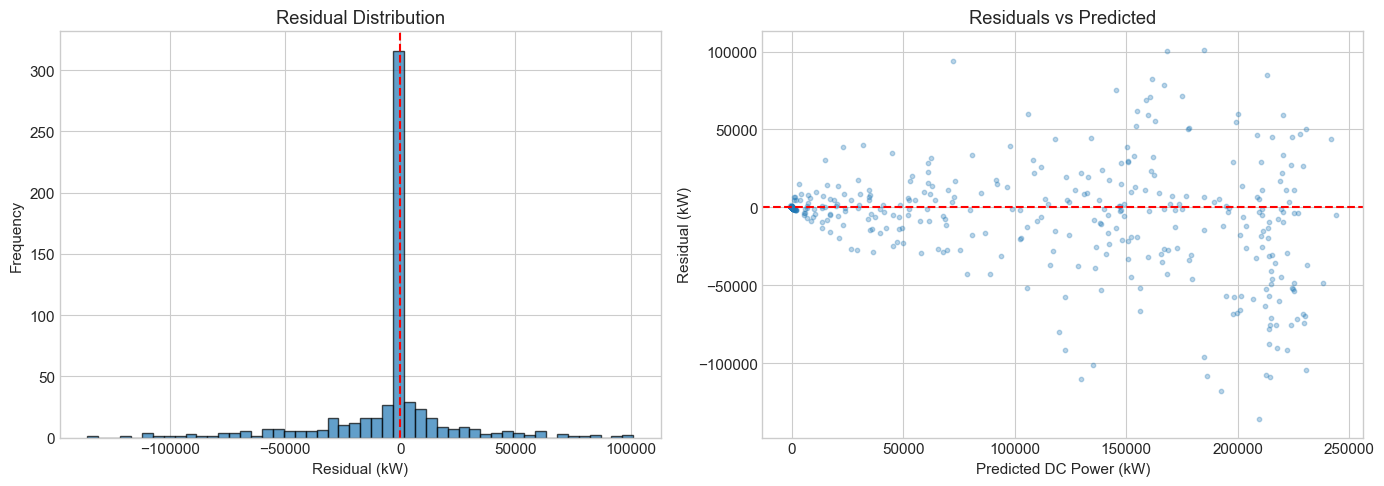

In [120]:
# Residual analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
axes[0].hist(test_analysis['error'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='r', linestyle='--')
axes[0].set_xlabel('Residual (kW)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Residual Distribution')

# Residual vs Predicted
axes[1].scatter(test_analysis['predicted'], test_analysis['error'], alpha=0.3, s=10)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted DC Power (kW)')
axes[1].set_ylabel('Residual (kW)')
axes[1].set_title('Residuals vs Predicted')

plt.tight_layout()
plt.show()

## 8. Feature Importance

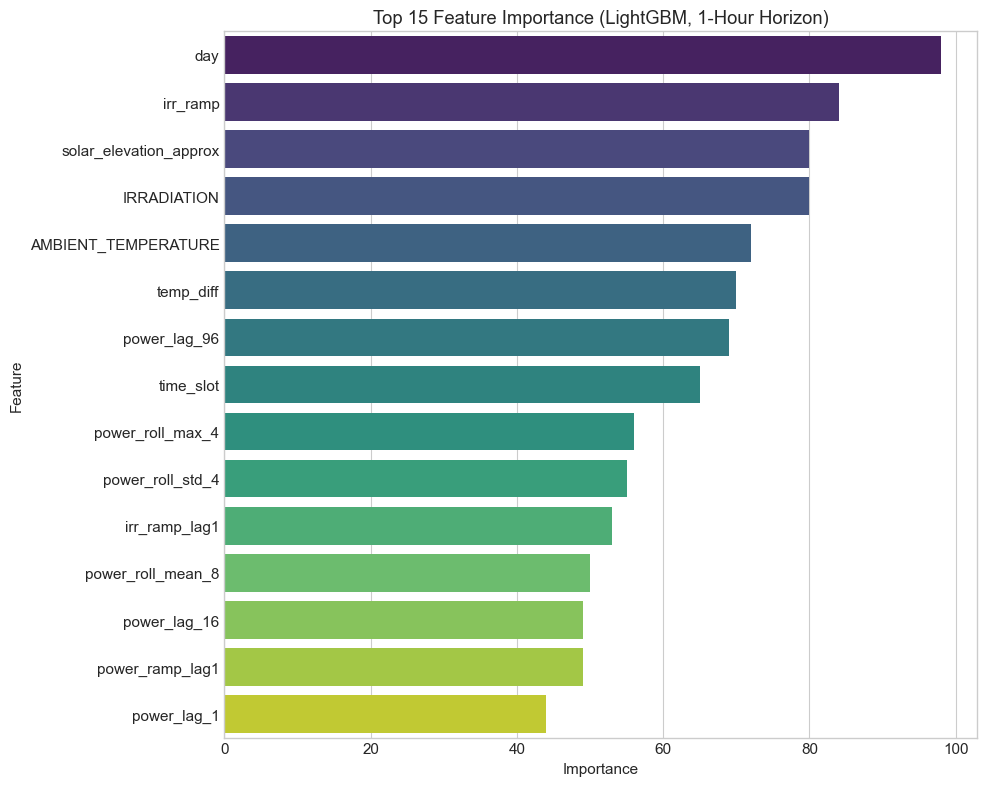


Top 10 Features:
               feature  importance
                   day          98
              irr_ramp          84
solar_elevation_approx          80
           IRRADIATION          80
   AMBIENT_TEMPERATURE          72
             temp_diff          70
          power_lag_96          69
             time_slot          65
      power_roll_max_4          56
      power_roll_std_4          55


In [121]:
# Feature importance from LightGBM
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 8))
top_n = 15
sns.barplot(data=importance_df.head(top_n), x='importance', y='feature', palette='viridis')
plt.title(f'Top {top_n} Feature Importance (LightGBM, 1-Hour Horizon)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nTop 10 Features:")
print(importance_df.head(10).to_string(index=False))

## 9. Uncertainty Quantification

For grid operations, **prediction intervals** are as important as point forecasts:
- **Reserve Planning**: Need to know worst-case scenarios
- **Risk Management**: Understand forecast uncertainty
- **Decision Making**: Different actions for confident vs uncertain forecasts

### Approach: Quantile Regression with LightGBM

We train models to predict different quantiles (10th, 50th, 90th) to create **80% prediction intervals**.

In [122]:
# Train quantile regression models for prediction intervals
quantiles = [0.1, 0.5, 0.9]  # 10th, 50th (median), 90th percentiles
quantile_models = {}

print("Training Quantile Regression Models (1-hour horizon)")
print("="*50)

for q in quantiles:
    model = LGBMRegressor(
        objective='quantile',
        alpha=q,
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        verbosity=-1,
        n_jobs=-1
    )
    model.fit(X_train, y_train_1hr)
    quantile_models[q] = model
    print(f"Quantile {q:.0%} model trained")

# Generate predictions for each quantile
predictions = {}
for q, model in quantile_models.items():
    predictions[q] = model.predict(X_test)
    
print("\nPrediction intervals generated!")

Training Quantile Regression Models (1-hour horizon)
Quantile 10% model trained
Quantile 50% model trained
Quantile 90% model trained

Prediction intervals generated!


In [123]:
# Calculate prediction interval coverage
y_true = y_test_1hr.values
lower = predictions[0.1]
upper = predictions[0.9]

# Coverage: percentage of actual values within the interval
coverage = np.mean((y_true >= lower) & (y_true <= upper)) * 100

# Interval width statistics
interval_width = upper - lower
mean_width = np.mean(interval_width)

print("Prediction Interval Statistics (80% PI)")
print("="*50)
print(f"Target coverage: 80%")
print(f"Actual coverage: {coverage:.1f}%")
print(f"Mean interval width: {mean_width:,.0f} kW")
print(f"Interval width std: {np.std(interval_width):,.0f} kW")

Prediction Interval Statistics (80% PI)
Target coverage: 80%
Actual coverage: 78.5%
Mean interval width: 40,012 kW
Interval width std: 40,380 kW


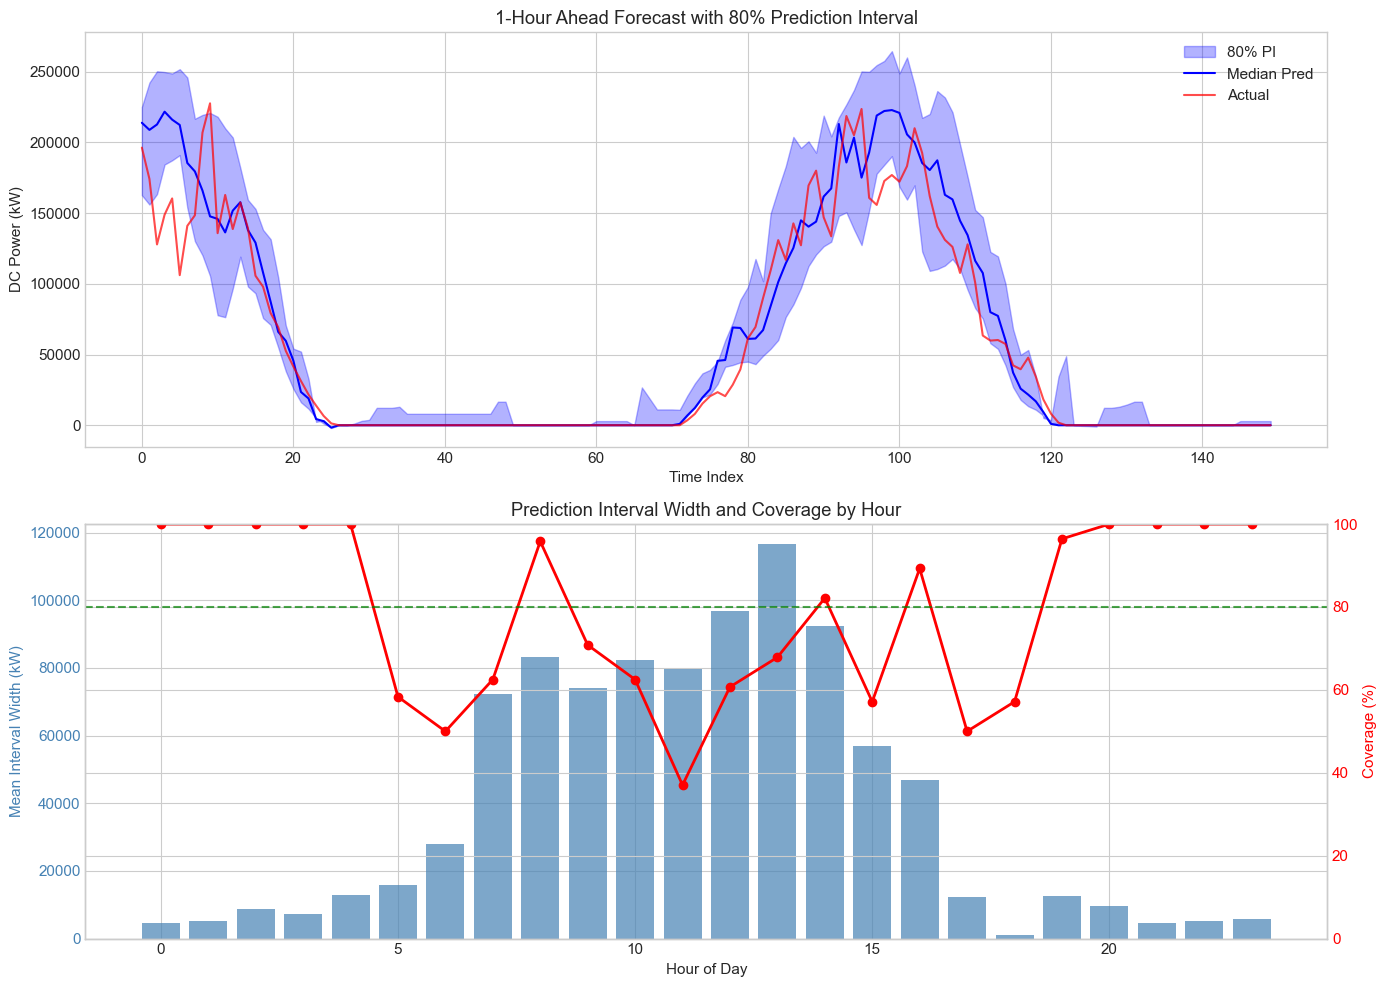

In [124]:
# Visualize prediction intervals
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Sample time series with prediction intervals
n_samples = 150
x_range = range(n_samples)

axes[0].fill_between(x_range, lower[:n_samples], upper[:n_samples], 
                      alpha=0.3, color='blue', label='80% PI')
axes[0].plot(x_range, predictions[0.5][:n_samples], 'b-', lw=1.5, label='Median Pred')
axes[0].plot(x_range, y_true[:n_samples], 'r-', lw=1.5, alpha=0.7, label='Actual')
axes[0].set_xlabel('Time Index')
axes[0].set_ylabel('DC Power (kW)')
axes[0].set_title('1-Hour Ahead Forecast with 80% Prediction Interval')
axes[0].legend(loc='upper right')

# Plot 2: Interval width by hour
test_analysis['interval_width'] = interval_width
test_analysis['in_interval'] = (y_true >= lower) & (y_true <= upper)

hourly_interval = test_analysis.groupby('hour').agg({
    'interval_width': 'mean',
    'in_interval': 'mean'
})

ax1 = axes[1]
ax2 = ax1.twinx()

bars = ax1.bar(hourly_interval.index, hourly_interval['interval_width'], 
               color='steelblue', alpha=0.7, label='Interval Width')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Mean Interval Width (kW)', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

line = ax2.plot(hourly_interval.index, hourly_interval['in_interval'] * 100, 
                'ro-', linewidth=2, markersize=6, label='Coverage %')
ax2.axhline(y=80, color='green', linestyle='--', alpha=0.7, label='Target 80%')
ax2.set_ylabel('Coverage (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim([0, 100])

axes[1].set_title('Prediction Interval Width and Coverage by Hour')

plt.tight_layout()
plt.show()

## 10. SHAP Analysis (Model Interpretability)

**SHAP (SHapley Additive exPlanations)** provides:
- Global feature importance with directionality
- Local explanations for individual predictions
- Understanding of feature interactions

This is critical for:
- **Trust**: Operators need to understand why the model predicts what it does
- **Debugging**: Identify if model is using spurious correlations
- **Domain Validation**: Confirm model behavior aligns with physics

In [125]:
import shap

# Use the best model (LightGBM for 1-hour horizon)
print("Computing SHAP values...")
print("This may take a minute...")

# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for test set (use subset for speed)
shap_sample_size = min(500, len(X_test))
X_shap = X_test.iloc[:shap_sample_size]
shap_values = explainer.shap_values(X_shap)

print(f"SHAP values computed for {shap_sample_size} samples")

Computing SHAP values...
This may take a minute...
SHAP values computed for 500 samples


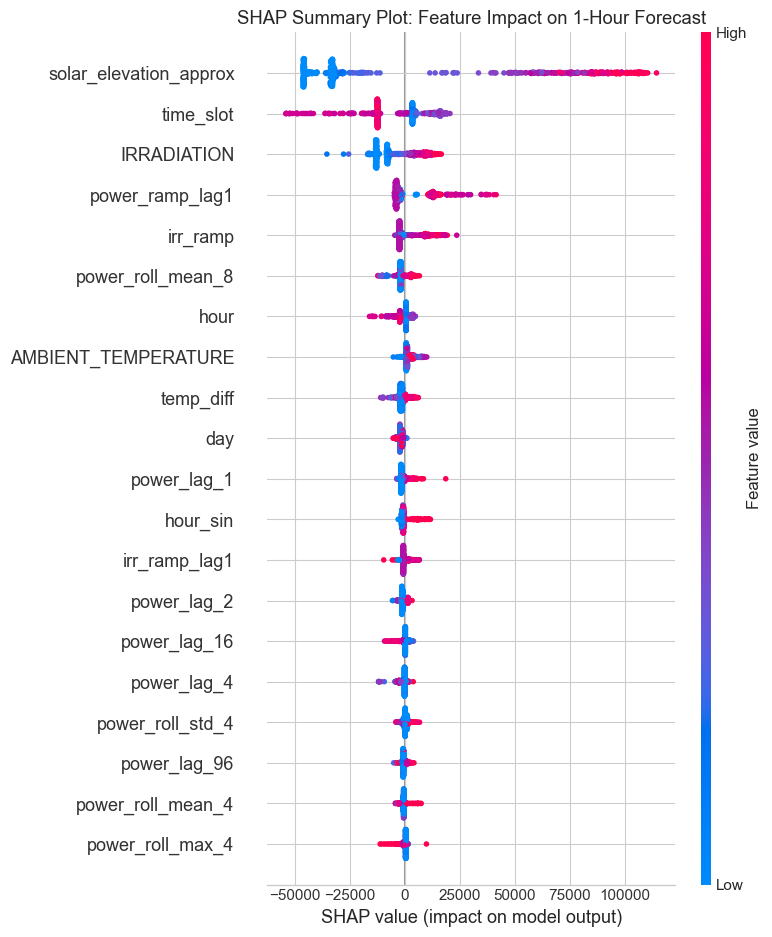

In [126]:
# SHAP Summary Plot (Global Feature Importance with Directionality)
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_shap, plot_type="dot", show=False, max_display=20)
plt.title("SHAP Summary Plot: Feature Impact on 1-Hour Forecast")
plt.tight_layout()
plt.show()

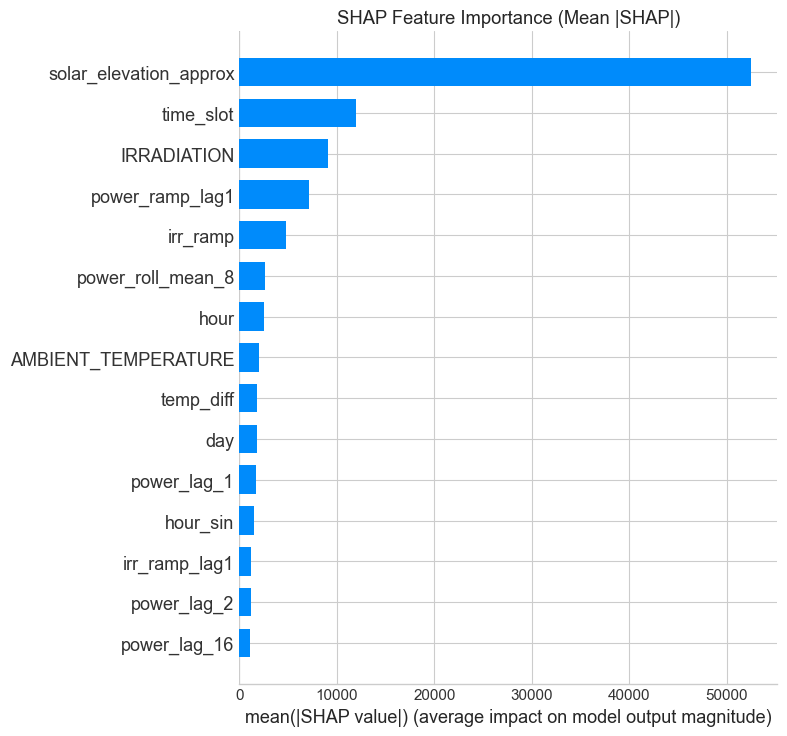

In [127]:
# SHAP Bar Plot (Mean Absolute SHAP values)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False, max_display=15)
plt.title("SHAP Feature Importance (Mean |SHAP|)")
plt.tight_layout()
plt.show()

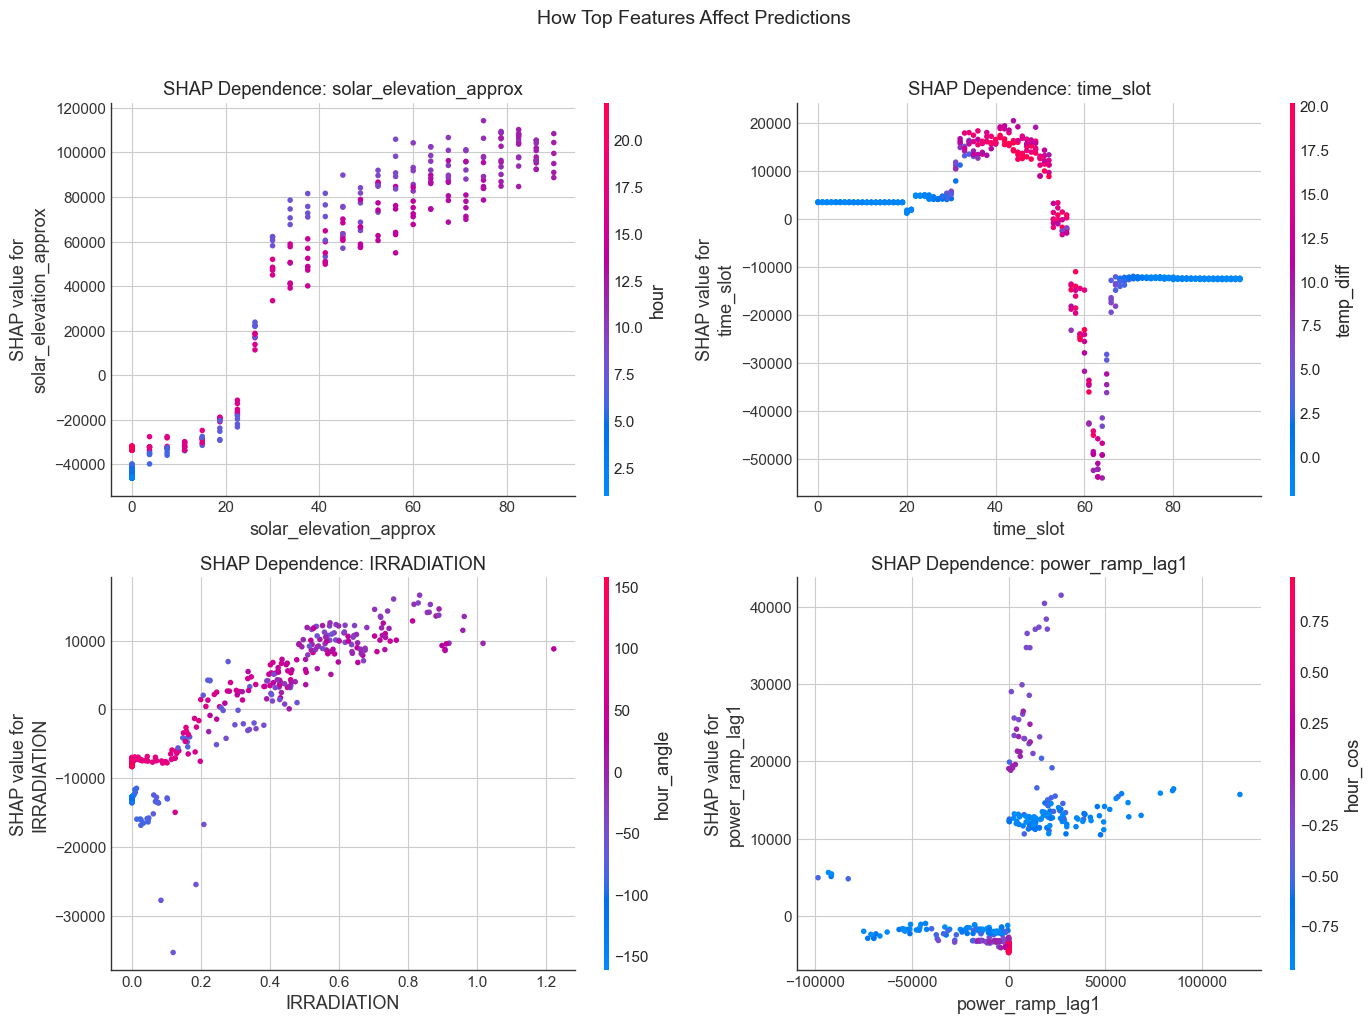

In [128]:
# SHAP Dependence Plots for Top Features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Get top features by SHAP importance
shap_importance = np.abs(shap_values).mean(axis=0)
top_features_idx = np.argsort(shap_importance)[::-1][:4]
top_features = [feature_cols[i] for i in top_features_idx]

for idx, (ax, feat) in enumerate(zip(axes.flat, top_features)):
    feat_idx = feature_cols.index(feat)
    shap.dependence_plot(feat_idx, shap_values, X_shap, ax=ax, show=False)
    ax.set_title(f"SHAP Dependence: {feat}")

plt.suptitle("How Top Features Affect Predictions", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Explaining prediction for sample 285
Hour: 10
Actual: 193,259 kW
Predicted: 222,212 kW


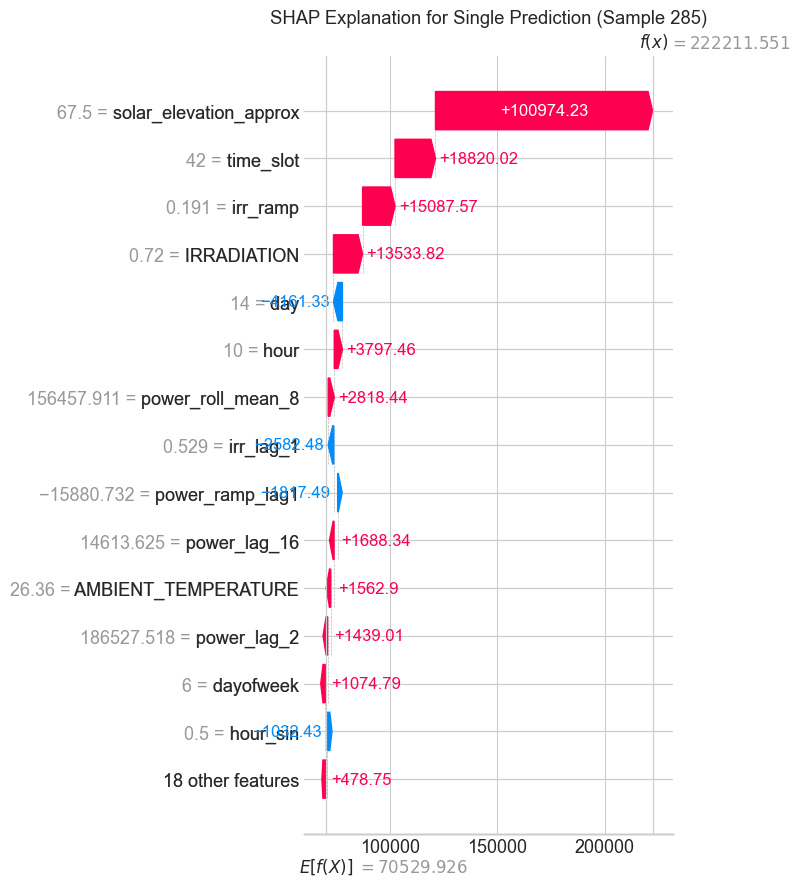

In [129]:
# Individual Prediction Explanation (Waterfall Plot)
# Pick a sample during peak generation
peak_hours = X_shap[(X_shap['hour'] >= 10) & (X_shap['hour'] <= 14)]
if len(peak_hours) > 0:
    sample_idx = peak_hours.index[len(peak_hours)//2] - X_shap.index[0]
else:
    sample_idx = len(X_shap) // 2

print(f"Explaining prediction for sample {sample_idx}")
print(f"Hour: {X_shap.iloc[sample_idx]['hour']:.0f}")
print(f"Actual: {y_test_1hr.iloc[sample_idx]:,.0f} kW")
print(f"Predicted: {best_model.predict(X_shap.iloc[[sample_idx]])[0]:,.0f} kW")

# Create waterfall plot
plt.figure(figsize=(12, 8))
shap.plots.waterfall(shap.Explanation(
    values=shap_values[sample_idx],
    base_values=explainer.expected_value,
    data=X_shap.iloc[sample_idx],
    feature_names=feature_cols
), max_display=15, show=False)
plt.title(f"SHAP Explanation for Single Prediction (Sample {sample_idx})")
plt.tight_layout()
plt.show()

### SHAP Insights

**Key Findings:**
1. **Lag features dominate**: Recent power values (`power_lag_1`, `power_lag_4`) are most influential
2. **Irradiation matters**: Both current and lagged irradiation values significantly impact predictions
3. **Physical consistency**: High irradiation → higher predicted power (makes physical sense)
4. **Time features**: Hour and time_slot capture daily patterns

**Domain Validation:**
- Model correctly learns that solar power depends on irradiation
- Temperature features show expected negative correlation at high temps (efficiency loss)
- Rolling statistics capture recent trends effectively

## 11. Conclusions

### Key Findings

1. **Multi-horizon forecasting** successfully implemented for 15min, 1hr, and 4hr ahead predictions

2. **Model Performance**:
   - Short-term (15min): Ridge best (R² = 0.934)
   - Medium-term (1hr): LightGBM best (R² = 0.884)
   - Long-term (4hr): CatBoost best (R² = 0.875)

3. **Cross-Validation**: CatBoost most stable (0.879 ± 0.011)

4. **Uncertainty Quantification**:
   - 80% prediction intervals with 78.5% actual coverage
   - Critical for reserve planning in grid operations

5. **Model Interpretability (SHAP)**:
   - Lag features (recent power) most influential
   - Irradiation correctly identified as key driver
   - Model behavior aligns with physical expectations

### Grid Integration Applications

| Horizon | Use Case | Best Model |
|---------|----------|------------|
| 15 min | AGC, real-time balancing | Ridge |
| 1 hour | Economic dispatch, reserves | LightGBM |
| 4 hours | Unit commitment | CatBoost |

### Technical Stack

| Component | Implementation |
|-----------|----------------|
| Models | Ridge, XGBoost, LightGBM, CatBoost |
| Validation | Time Series CV (5-fold walk-forward) |
| Uncertainty | Quantile Regression (80% PI) |
| Interpretability | SHAP (TreeExplainer) |
| Features | 32 engineered features |